In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv


df = pd.read_csv('../Datasets/processed_data.csv')
df_advertiser = pd.read_csv('../Datasets/advertiser_embeddings.csv')
df_keywords = pd.read_csv('../Datasets/keyword_embeddings.csv')
df_search_tags = pd.read_csv('../Datasets/search_tag_embeddings.csv')



In [2]:
df = pd.concat([df, df_advertiser, df_keywords, df_search_tags], axis=1)

In [3]:
# The corresponding class labels for each record
engagement_levels = torch.tensor(df['engagement_level'].values, dtype=torch.long)  # Use long dtype for class indices

# Ensure shapes are appropriate
print(f"engagement shape: {engagement_levels.shape}")
print(f"Unique classes: {torch.unique(engagement_levels)}")
print(f"Class distribution: {torch.bincount(engagement_levels)}")

engagement shape: torch.Size([58930])
Unique classes: tensor([0, 1, 2])
Class distribution: tensor([24488, 18074, 16368])


In [4]:
# Initialize HeteroData object
data = HeteroData()

campaign_data = df[['campaign_index','no_of_days', 'campaign_budget_usd']]
# Convert to tensor format
campaign_features = torch.tensor(campaign_data.values, dtype=torch.float)
# data['campaign'] is the campaign node feature storage
data['campaign'].x = campaign_features


platform_data = df[['DV360', 'Facebook Ads', 'Google Ads']]
# Convert to tensor format
platform_features = torch.tensor(platform_data.values, dtype=torch.float)
# data['platform'] is the platform node feature storage
data['platform'].x = platform_features


channel_data = df[['Display', 'Mobile', 
                   'Search', 'Social', 'Video']]
# Convert to tensor format
channel_features = torch.tensor(channel_data.values, dtype=torch.float)
# data['channel'] is the channel node feature storage
data['channel'].x = channel_features


creative_data = df[['has_image']]
# Convert to tensor format
creative_features = torch.tensor(creative_data.values, dtype=torch.float)
# data['creative'] is the creative node feature storage
data['creative'].x = creative_features


keyword_data = df[[f'keyword_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Convert to tensor format
keyword_features = torch.tensor(keyword_data.values, dtype=torch.float)
# Store in the data dictionary for keyword nodes
data['keywords'].x = keyword_features


advertiser_data = df[[f'advertiser_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Concatenate advertiser_id with the embeddings -> Resulting shape (69,000, 51)
advertiser_features = torch.tensor(advertiser_data.values, dtype=torch.float)
# Assign to the advertiser node in your graph
data['advertiser'].x = advertiser_features


search_tags_data = df[[f'search_tag_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Convert to tensor format
search_tag_features = torch.tensor(search_tags_data.values, dtype=torch.float)
# Store in the data dictionary for keyword nodes
data['search_tag'].x = search_tag_features

template_data = df[['template_id']]
# Convert to tensor format
template_features = torch.tensor(template_data.values, dtype=torch.float)
# data['template'] is the template node feature storage
data['template'].x = template_features

network_data = df[['network_id']]
# Convert to tensor format
network_features = torch.tensor(network_data.values, dtype=torch.float)
# data['network'] is the network node feature storage
data['network'].x = network_features

region_data = df[['Africa/Cairo','America/New_York','Asia/Calcutta',
                'Asia/Kolkata', 'Asia/Muscat' ,'Asia/Singapore', 'US/Eastern']]
# Convert to tensor format
region_features = torch.tensor(region_data.values, dtype=torch.float)
# data['region'] is the region node feature storage
data['region'].x = region_features

currency_data = df[['AED','EGP','INR','SGD','USD']]
# Convert to tensor format
currency_features = torch.tensor(currency_data.values, dtype=torch.float)
# data['currency'] is the currency node feature storage
data['currency'].x = currency_features

In [5]:

# Edges (Campaign → Platform)
data['campaign', 'hosted_on', 'platform'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # platform indices
], dtype=torch.long)


data['platform', 'rev_hosted_on', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # platform indices
    [0, 1]   # campaign indices
], dtype=torch.long)


# Edges (Campaign → Channel)
data['campaign', 'uses', 'channel'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)

data['channel', 'rev_uses', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # channel indices
    [0, 1]   # campaign indices
], dtype=torch.long)


# Edges (Platform → channel)
data['platform', 'supports', 'channel'].edge_index = torch.tensor([
    [0, 1],  # platform indices
    [0, 1]   # channel indices
], dtype=torch.long)


# Edges (Campaign → Creative)
data['campaign', 'uses', 'creative'].edge_index = torch.tensor([
    [0, 1],  # creative indices
    [0, 1]   # campaign indices
], dtype=torch.long)

data['creative', 'rev_uses', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # creative indices
    [0, 1]   # campaign indices
], dtype=torch.long)

# Edges (Creative → Template)
data['creative', 'designed_with', 'template'].edge_index = torch.tensor([
    [0, 1],  # creative indices
    [0, 1]   # template indices
], dtype=torch.long)


data['campaign', 'associated_with', 'keywords'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['keywords', 'rev_associated_with', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # channel indices
    [0, 1]   # campaign indices
], dtype=torch.long)    


data['platform', 'optimized_for', 'keywords'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['campaign', 'managed_by', 'network'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['campaign','belongs_to','advertiser'].edge_index = torch.tensor([
    [0, 1],
    [0, 1]
], dtype=torch.long)

# Edges (Campaign → Search Tag)
data['campaign', 'targeted_with', 'search_tag'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # search tag indices
], dtype=torch.long)

data['search_tag', 'rev_targeted_with', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # search tag indices
    [0, 1]   # campaign indices
], dtype=torch.long)

data['campaign', 'targeted_in', 'region'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # region indices
], dtype=torch.long)

data['campaign', 'uses', 'currency'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # currency indices
], dtype=torch.long)


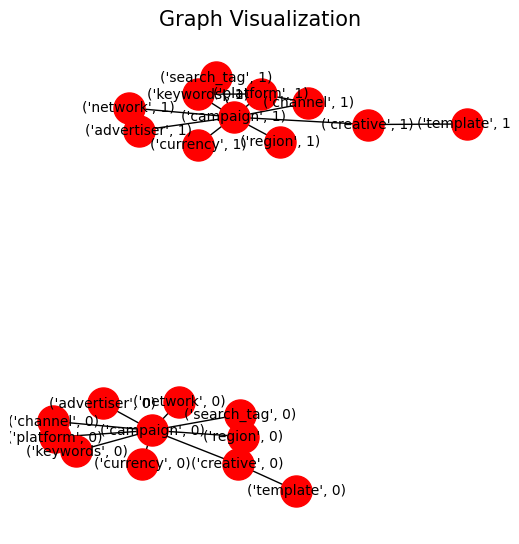

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
import torch

def visualize_graph(data):
    # Create a new graph using NetworkX
    G = nx.Graph()

    # Add nodes and edges to the graph
    for edge_type, edge_index in data.edge_index_dict.items():
        src_type, _, dst_type = edge_type  # Extract source and destination node types
        for src, dst in edge_index.t().tolist():  # Add edges to the graph
            # Add nodes as (node_type, node_id)
            G.add_node((src_type, src))
            G.add_node((dst_type, dst))
            G.add_edge((src_type, src), (dst_type, dst))
    
    # Position nodes using the spring layout (force-directed layout)
    pos = nx.spring_layout(G)

    # Draw the graph
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='red', font_size=10)
    plt.title("Graph Visualization", fontsize=15)
    plt.show()

# Visualize the graph
visualize_graph(data)


In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, GATConv  # Changed from SAGEConv to GATConv
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class HeteroGCN(torch.nn.Module):
    def __init__(self, hidden_dim, num_classes, num_layers=3, heads=4):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.heads = heads

        # Define the relations
        self.relations = [
            ('campaign', 'hosted_on', 'platform'),
            ('platform', 'rev_hosted_on', 'campaign'),
            ('campaign', 'uses', 'channel'),
            ('channel', 'rev_uses', 'campaign'),
            ('platform', 'supports', 'channel'),
            ('campaign', 'uses', 'creative'),
            ('creative', 'rev_uses', 'campaign'),
            ('creative', 'designed_with', 'template'),
            ('campaign', 'associated_with', 'keywords'),
            ('keywords', 'rev_associated_with', 'campaign'),
            ('campaign', 'managed_by', 'network'),
            ('platform', 'optimized_for', 'keywords'),
            ('campaign', 'belongs_to', 'advertiser'),
            ('campaign', 'targeted_with', 'search_tag'),
            ('search_tag', 'rev_targeted_with', 'campaign'),
            ('campaign', 'targeted_in', 'region'),
            ('campaign', 'uses', 'currency')
        ]

        # Create HeteroConv layers with GATConv
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers):
            conv_dict = {}
            for rel in self.relations:
                in_channels = -1 if i == 0 else hidden_dim
                conv_dict[rel] = GATConv(
                    (in_channels, in_channels),
                    hidden_dim // heads,
                    heads=heads,
                    concat=True,
                    add_self_loops=False,
                    dropout=0.2
                )
            self.convs.append(HeteroConv(conv_dict, aggr='mean'))

        self.norms = torch.nn.ModuleList([torch.nn.LayerNorm(hidden_dim) for _ in range(num_layers)])
        
        self.attention = torch.nn.MultiheadAttention(hidden_dim*11, num_heads=4, dropout=0.2)
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim*11, hidden_dim*4),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(hidden_dim*4, num_classes)
        )

    def forward(self, x_dict, edge_index_dict):
        for conv, norm in zip(self.convs, self.norms):
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.elu(norm(x)) for key, x in x_dict.items()}

        # Get all node features
        x_combined = torch.cat([
            x_dict['campaign'], x_dict['platform'], x_dict['channel'],
            x_dict['creative'], x_dict['keywords'], x_dict['search_tag'],
            x_dict['advertiser'], x_dict['network'], x_dict['template'],
            x_dict['region'], x_dict['currency']
        ], dim=1)

        # Attention
        attn_out, _ = self.attention(
            x_combined.unsqueeze(0),
            x_combined.unsqueeze(0),
            x_combined.unsqueeze(0)
        )
        x_combined = x_combined + 0.3 * attn_out.squeeze(0)
        
        return self.classifier(x_combined)

In [8]:
def train(model, data, optimizer, criterion, target_node_type='campaign', batch_size=64):
    model.train()
    
    # Get all campaign node indices
    num_nodes = data[target_node_type].x.size(0)
    indices = torch.randperm(num_nodes)
    
    total_loss = 0
    total_correct = 0
    
    for start in range(0, num_nodes, batch_size):
        end = min(start + batch_size, num_nodes)
        batch_indices = indices[start:end]
        
        optimizer.zero_grad()
        
        # Forward pass for the batch
        out = model(data.x_dict, data.edge_index_dict)
        batch_out = out[batch_indices]
        
        # Get labels for the batch
        y = data[target_node_type].y[batch_indices]
        
        # Compute loss
        loss = criterion(batch_out, y)
        loss.backward()
        optimizer.step()
        
        # Compute accuracy
        pred = batch_out.argmax(dim=1)
        correct = (pred == y).sum().item()
        
        total_loss += loss.item() * (end - start)
        total_correct += correct
    
    avg_loss = total_loss / num_nodes
    avg_acc = total_correct / num_nodes
    
    return avg_loss, avg_acc

@torch.no_grad()
def evaluate(model, data, criterion, target_node_type='campaign'):
    model.eval()
    
    # Forward pass for all nodes
    out = model(data.x_dict, data.edge_index_dict)
    y = data[target_node_type].y
    
    # Compute loss and accuracy
    loss = criterion(out, y).item()
    pred = out.argmax(dim=1)
    correct = (pred == y).sum().item()
    acc = correct / len(y)
    
    return loss, acc

def run_training(model, data, target_node_type='campaign', epochs=100, lr=0.005, weight_decay=5e-4):
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
    criterion = torch.nn.CrossEntropyLoss()
    
    # Split data manually if you want train/val/test
    num_nodes = data[target_node_type].x.size(0)
    indices = torch.randperm(num_nodes)
    train_idx = indices[:int(0.8 * num_nodes)]  # 80% train
    val_idx = indices[int(0.8 * num_nodes):]    # 20% val
    
    best_val_acc = 0
    best_model = None
    
    for epoch in range(1, epochs+1):
        # Train on training indices
        train_loss, train_acc = train(
            model, 
            data, 
            optimizer, 
            criterion, 
            target_node_type
        )
        
        # Evaluate on validation indices
        model.eval()
        with torch.no_grad():
            out = model(data.x_dict, data.edge_index_dict)
            val_out = out[val_idx]
            val_y = data[target_node_type].y[val_idx]
            val_loss = criterion(val_out, val_y).item()
            val_pred = val_out.argmax(dim=1)
            val_correct = (val_pred == val_y).sum().item()
            val_acc = val_correct / len(val_y)
        
        scheduler.step()
        
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict()
    
    # Load best model
    model.load_state_dict(best_model)
    
    # Final evaluation on all data (or you can keep a separate test set)
    final_loss, final_acc = evaluate(model, data, criterion, target_node_type)
    print(f'Final Loss: {final_loss:.4f}, Final Acc: {final_acc:.4f}')
    
    return model

In [9]:
data['campaign'].y = torch.tensor(df['engagement_level'].values, dtype=torch.long)  # Your 3-class labels


print("Unique labels in dataset:", torch.unique(data['campaign'].y))
print("Max label value:", data['campaign'].y.max().item())
print("Min label value:", data['campaign'].y.min().item())

Unique labels in dataset: tensor([0, 1, 2])
Max label value: 2
Min label value: 0


In [10]:
# Initialize model
hidden_dim = 128
num_classes = 3
model = HeteroGCN(hidden_dim=hidden_dim, num_classes=num_classes).to(device)

# Make sure you have labels in your data

# Run training
trained_model = run_training(model, data)

# To predict on new data:
model.eval()
with torch.no_grad():
    predictions = model(data.x_dict, data.edge_index_dict).argmax(dim=1)

KeyboardInterrupt: 

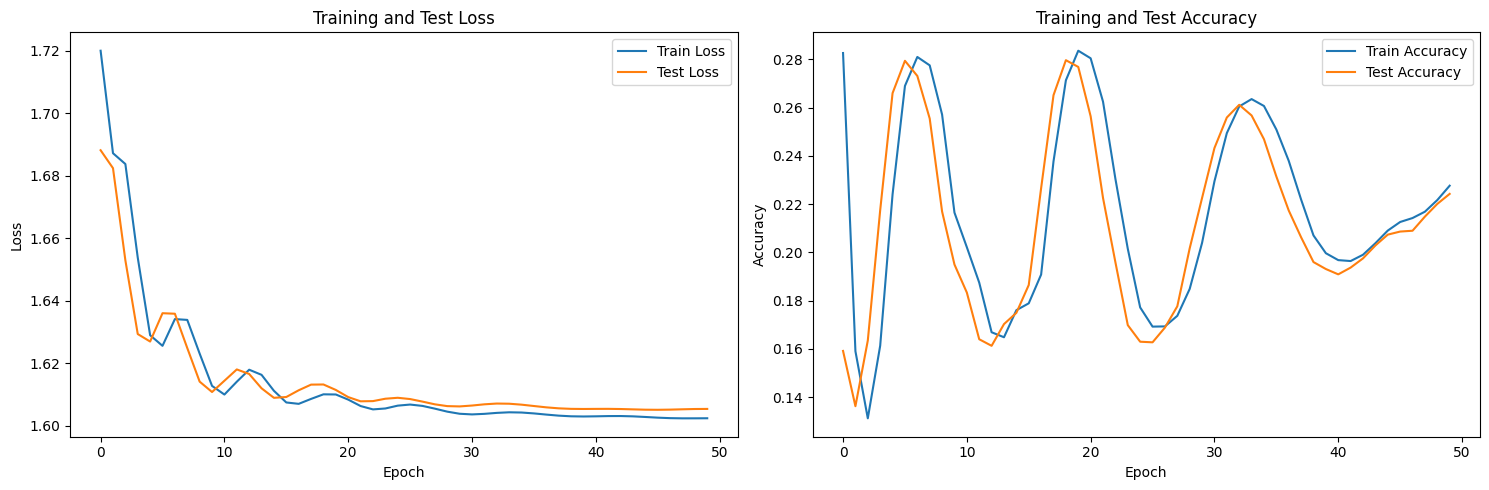


Final Evaluation:
              precision    recall  f1-score   support

           0     0.5087    1.0000    0.6743      5995
           1     0.0000    0.0000    0.0000      5791

    accuracy                         0.5087     11786
   macro avg     0.2543    0.5000    0.3372     11786
weighted avg     0.2587    0.5087    0.3430     11786


Detailed Class Metrics:


c:\Users\Thinkpad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Thinkpad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Thinkpad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

              precision    recall  f1-score       support
0              0.508654  1.000000  0.674315   5995.000000
1              0.000000  0.000000  0.000000   5791.000000
accuracy       0.508654  0.508654  0.508654      0.508654
macro avg      0.254327  0.500000  0.337158  11786.000000
weighted avg   0.258729  0.508654  0.342993  11786.000000


In [ ]:
def plot_metrics(metrics):
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['test_loss'], label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_acc'], label='Train Accuracy')
    plt.plot(metrics['test_acc'], label='Test Accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Generate plots
plot_metrics(metrics)

# Final evaluation on test set
model.eval()
with torch.no_grad():
    test_logits = model(data.x_dict, data.edge_index_dict)
    test_preds = test_logits.argmax(dim=1)[test_idx]
    y_true = engagement_levels[test_idx].cpu().numpy()
    y_pred = test_preds.cpu().numpy()
    
    print("\nFinal Evaluation:")
    print(classification_report(y_true, y_pred, digits=4))
    
    # Per-class metrics
    class_report = classification_report(y_true, y_pred, output_dict=True)
    class_metrics = pd.DataFrame(class_report).transpose()
    print("\nDetailed Class Metrics:")
    print(class_metrics)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv

# Assuming your model is defined as 'model'

# New data for prediction (single data point)
new_campaign = torch.tensor([[1000, 3, 8]], dtype=torch.float)  # Single new campaign feature (1 new campaign)

new_platform = torch.tensor([[0, 1, 0]], dtype=torch.float)  # Single new platform feature (1 new platform)

new_channel = torch.tensor([[0, 0, 0, 0, 1]], dtype=torch.float)  # Single new channel feature (1 new channel)

new_creative = torch.tensor([[1]], dtype=torch.float)  # Single new creative feature (1 new creative)

new_template = torch.tensor([[91]], dtype=torch.float)  # Single new template feature (1 new template)

new_network = torch.tensor([[190]], dtype=torch.float)  # Single new network feature (1 new network)

new_keywords = torch.rand((1, 50), dtype=torch.float)  # Single new keywords feature (1 new keywords)

new_advertiser = torch.rand((1, 50), dtype=torch.float)  # Single new advertiser feature (1 new advertiser)

new_search_tag = torch.rand((1, 50), dtype=torch.float)  # Single new advertiser feature (1 new advertiser)

new_region = torch.tensor([[0, 0, 0, 0, 0, 0, 1]], dtype=torch.float)  # Single new region feature (1 new region)

new_currency = torch.tensor([[0, 0, 0, 0, 1]], dtype=torch.float)  # Single new currency feature (1 new currency)


# Add the new nodes and their features to the graph
data['campaign'].x = torch.cat([data['campaign'].x, new_campaign], dim=0)
data['platform'].x = torch.cat([data['platform'].x, new_platform], dim=0)
data['channel'].x = torch.cat([data['channel'].x, new_channel], dim=0)
data['creative'].x = torch.cat([data['creative'].x, new_creative], dim=0)
data['template'].x = torch.cat([data['template'].x, new_template], dim=0)
data['network'].x = torch.cat([data['network'].x, new_network], dim=0)
data['keywords'].x = torch.cat([data['keywords'].x, new_keywords], dim=0)
data['advertiser'].x = torch.cat([data['advertiser'].x, new_advertiser], dim=0)
data['search_tag'].x = torch.cat([data['search_tag'].x, new_search_tag], dim=0)
data['region'].x = torch.cat([data['region'].x, new_region], dim=0)
data['currency'].x = torch.cat([data['currency'].x, new_currency], dim=0)

new_campaign_index = data['campaign'].x.size(0) - 1
new_platform_index = data['platform'].x.size(0) - 1
new_channel_index = data['channel'].x.size(0) - 1
new_creative_index = data['creative'].x.size(0) - 1
new_template_index = data['template'].x.size(0) - 1
new_network_index = data['network'].x.size(0) - 1
new_keywords_index = data['keywords'].x.size(0) - 1
new_advertiser_index = data['advertiser'].x.size(0) - 1
new_search_tag_index = data['search_tag'].x.size(0) - 1
new_region_index = data['region'].x.size(0) - 1
new_currency_index = data['currency'].x.size(0) - 1



data['campaign', 'hosted_on', 'platform'].edge_index = torch.cat(
    [data['campaign', 'hosted_on', 'platform'].edge_index,
     torch.tensor([[new_campaign_index], [new_platform_index]], dtype=torch.long)], dim=1
)

data['platform', 'rev_hosted_on', 'campaign'].edge_index = torch.cat(
    [data['platform', 'rev_hosted_on', 'campaign'].edge_index,
     torch.tensor([[new_platform_index], [new_campaign_index]], dtype=torch.long)], dim=1
)

data['campaign', 'uses', 'channel'].edge_index = torch.cat(
    [data['campaign', 'uses', 'channel'].edge_index,
     torch.tensor([[new_campaign_index], [new_channel_index]], dtype=torch.long)], dim=1
)

data['channel', 'rev_uses', 'campaign'].edge_index = torch.cat(
    [data['channel', 'rev_uses', 'campaign'].edge_index,
     torch.tensor([[new_channel_index], [new_campaign_index]], dtype=torch.long)], dim=1
)

data['platform', 'supports', 'channel'].edge_index = torch.cat(
    [data['platform', 'supports', 'channel'].edge_index,
     torch.tensor([[new_platform_index], [new_channel_index]], dtype=torch.long)], dim=1
)


data['campaign', 'uses', 'creative'].edge_index = torch.cat(
    [data['campaign', 'uses', 'creative'].edge_index,
     torch.tensor([[new_campaign_index], [new_creative_index]], dtype=torch.long)], dim=1
)

data['creative', 'designed_with', 'template'].edge_index = torch.cat(
    [data['creative', 'designed_with', 'template'].edge_index,
     torch.tensor([[new_creative_index], [new_template_index]], dtype=torch.long)], dim=1
)

data['campaign', 'associated_with', 'keywords'].edge_index = torch.cat(
    [data['campaign', 'associated_with', 'keywords'].edge_index,
     torch.tensor([[new_campaign_index], [new_keywords_index]], dtype=torch.long)], dim=1
)

data['campaign', 'managed_by', 'network'].edge_index = torch.cat(
    [data['campaign', 'managed_by', 'network'].edge_index,
     torch.tensor([[new_campaign_index], [new_network_index]], dtype=torch.long)], dim=1
)

data['platform', 'optimized_for', 'keywords'].edge_index = torch.cat(
    [data['platform', 'optimized_for', 'keywords'].edge_index,
     torch.tensor([[new_platform_index], [new_keywords_index]], dtype=torch.long)], dim=1
)

data['campaign', 'belongs_to', 'advertiser'].edge_index = torch.cat(
    [data['campaign', 'belongs_to', 'advertiser'].edge_index,
     torch.tensor([[new_campaign_index], [new_advertiser_index]], dtype=torch.long)], dim=1
)

data['campaign', 'targeted_with', 'search_tag'].edge_index = torch.cat(
    [data['campaign', 'targeted_with', 'search_tag'].edge_index,
     torch.tensor([[new_campaign_index], [new_search_tag_index]], dtype=torch.long)], dim=1
)


data['search_tag', 'rev_targeted_with', 'campaign'].edge_index = torch.cat(
    [data['search_tag', 'rev_targeted_with', 'campaign'].edge_index,
     torch.tensor([[new_campaign_index], [new_search_tag_index]], dtype=torch.long)], dim=1
)

data['campaign', 'targeted_in', 'region'].edge_index = torch.cat(
    [data['campaign', 'targeted_in', 'region'].edge_index,
     torch.tensor([[new_campaign_index], [new_region_index]], dtype=torch.long)], dim=1
)

data['campaign', 'uses', 'currency'].edge_index = torch.cat(
    [data['campaign', 'uses', 'currency'].edge_index,
     torch.tensor([[new_campaign_index], [new_currency_index]], dtype=torch.long)], dim=1
)

In [ ]:
# Run model inference
model.eval()
with torch.no_grad():
    output = model(data.x_dict, data.edge_index_dict)

new_campaign_pred = output[-1]  # Assuming last row corresponds to the new campaign
print("Predicted clicks for new campaign:", new_campaign_pred.item())

RuntimeError: a Tensor with 2 elements cannot be converted to Scalar

In [ ]:
print("First 10 predictions:\n", output[:10])
print("Output shape:", output.shape)
print("Number of campaign nodes:", len(data.x_dict['campaign']))


First 10 predictions:
 tensor([0.2945, 0.4293, 0.4099, 0.4105, 0.4146, 0.4119, 0.4130, 0.4089, 0.4092,
        0.4145])
Output shape: torch.Size([58931])
Number of campaign nodes: 58931


In [ ]:
torch.save(model.state_dict(), "sage_model.pth")  # ✅ Save only weights
